# **ZDT3** Problem

In [ ]:
%pip install pymoo --quiet

In [1]:
import numpy as np
from pymoo.problems import get_problem
from pymoo.indicators.hv import Hypervolume
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.algorithms.moo.age import AGEMOEA

## Funciones Auxiliares


In [2]:
#CALCULO DE MÉTRICAS
def calculate_metrics(front, ref_point):
    """Calcula las métricas: hipervolumen, dispersión (SPR) y espaciado (SPA)."""
    metricHV = Hypervolume(ref_point)
    hv = metricHV.do(front)

    # Dispersión: Diagonal de la hipercaja que contiene el frente
    min_values = np.min(front, axis=0)
    max_values = np.max(front, axis=0)
    spr = np.linalg.norm(max_values - min_values)

    # Espaciado: Distancia promedio entre puntos del frente
    d = np.linalg.norm(front[:, None, :] - front[None, :, :], axis=-1)
    spa = np.mean(np.min(d + np.diag(np.inf * np.ones(len(d))), axis=1))

    return hv, spr, spa


# **Algoritmos**

Se utilizan tres algoritmos para abordar problemas de optimización multiobjetivo, dos son implementaDOS USANDO PYMOO:
- **NSGA-II (Non-dominated Sorting Genetic Algorithm II)**
  NSGA-II se basa en la dominancia no dominada para clasificar las soluciones en diferentes frentes de Pareto. Su principal enfoque es mantener la diversidad entre las soluciones y asegurar que se mantengan un conjunto de soluciones no dominadas que representen bien el frente de Pareto. Utiliza un proceso de selección por torneo, y a través de operaciones de cruzamiento y mutación, genera nuevas soluciones. La selección de las mejores soluciones se realiza por un proceso de clasificación de frentes.

- **AGEMOEA (Adaptive Genetic and Evolutionary Multi-objective Evolutionary Algorithm)**
  A diferencia de NSGA-II, AGEMOEA tiene un enfoque adaptativo, ajustando dinámicamente parámetros como la tasa de mutación o cruzamiento durante el proceso evolutivo, dependiendo del comportamiento del algoritmo. Este ajuste adaptativo le permite ajustarse mejor a las características del problema, mejorando la convergencia y la distribución de soluciones en un espacio multiobjetivo. Aunque también utiliza operaciones de cruzamiento y mutación, la principal diferencia es su capacidad para modificar su estrategia de optimización en función de cómo evoluciona la población

El último es una propuesta obtenida del paper Li, H., & Zhang, Q. (2008). Multiobjective optimization problems with complicated Pareto sets, MOEA/D and NSGA-II. IEEE Transactions on Evolutionary Computation, 13(2), 284-302.
- **MOEA/D-DE (Multi-objective Evolutionary Algorithm based on Decomposition and Differential Evolution)**
  MOEA/D-DE se basa en la descomposición del problema multiobjetivo en varios subproblemas más simples, a los cuales se les aplica un enfoque de evolución diferencial. Cada subproblema se resuelve de forma independiente utilizando evolución diferencial, lo que permite una optimización más directa y especializada para cada subproblema. Este enfoque es especialmente útil en problemas con un conjunto de Pareto complicado o de alta dimensión. A diferencia de los otros dos algoritmos, MOEA/D-DE no utiliza dominancia no dominada ni clasificación por frentes, sino que se enfoca en resolver subproblemas, lo que le permite manejar mejor problemas con Pareto más complejo.


In [3]:
##### PROBLEMA ZDT3 #####

problem = get_problem("zdt3")
ref_point = np.array([1.5, 4])  
n_gen = 100  
pop_size = 100 


### ALGORITMOS MULTIOBJETIVO PYMOO #####

#1. NSGA-II
algorithm_nsgaii = NSGA2(pop_size=pop_size)
res_nsgaii = minimize(problem,
                      algorithm_nsgaii,
                      ('n_gen', n_gen),
                      verbose=False)

# 2. AGEMOEA
algorithm_agemoea = AGEMOEA(pop_size=pop_size)
res_agemoea = minimize(problem,
                       algorithm_agemoea,
                       ('n_gen', n_gen),
                       verbose=False)


In [4]:
#### ALGORITMO PROPUESTO MOEA/D-DE ####

'''
Código y algoritmo perteneciente al paper:

Multi-objective evolutionary algorithm based on decomposition and differential evolution
Reference: Li H, Zhang Q. Multiobjective optimization problems with complicated Pareto sets, 
MOEA/D and NSGA-II[J]. IEEE Transactions on Evolutionary Computation, 2008, 13(2): 284-302
'''
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from scipy.spatial.distance import pdist, squareform


def cal_obj(x):
    # ZDT3
    if np.any(x < 0) or np.any(x > 1):
        return [np.inf, np.inf]
    f1 = x[0]
    num1 = 0
    for i in range(1, len(x)):
        num1 += x[i]
    g = 1 + 9 * num1 / (len(x) - 1)
    f2 = g * (1 - np.sqrt(x[0] / g) - x[0] / g * np.sin(10 * np.pi * x[0]))
    return [f1, f2]


def factorial(n):
    if n == 0 or n == 1:
        return 1
    else:
        return n * factorial(n - 1)


def combination(n, m):
    # elegir m elementos de conjunto de n
    if m == 0 or m == n:
        return 1
    elif m > n:
        return 0
    else:
        return factorial(n) // (factorial(m) * factorial(n - m))


def reference_points(npop, dim):
    # calcular aproximadamente npop puntos de referencia distribuidos uniformemente en dim dimensiones
    h1 = 0
    while combination(h1 + dim, dim - 1) <= npop:
        h1 += 1
    points = np.array(list(combinations(np.arange(1, h1 + dim), dim - 1))) - np.arange(dim - 1) - 1
    points = (np.concatenate((points, np.zeros((points.shape[0], 1)) + h1), axis=1) - np.concatenate((np.zeros((points.shape[0], 1)), points), axis=1)) / h1
    if h1 < dim:
        h2 = 0
        while combination(h1 + dim - 1, dim - 1) + combination(h2 + dim, dim - 1) <= npop:
            h2 += 1
        if h2 > 0:
            temp_points = np.array(list(combinations(np.arange(1, h2 + dim), dim - 1))) - np.arange(dim - 1) - 1
            temp_points = (np.concatenate((temp_points, np.zeros((temp_points.shape[0], 1)) + h2), axis=1) - np.concatenate((np.zeros((temp_points.shape[0], 1)), temp_points), axis=1)) / h2
            temp_points = temp_points / 2 + 1 / (2 * dim)
            points = np.concatenate((points, temp_points), axis=0)
    points = np.where(points != 0, points, 1e-3)
    return points


def dominates(obj1, obj2):
    # ver si obj1 domina obj2
    sum_less = 0
    for i in range(len(obj1)):
        if obj1[i] > obj2[i]:
            return False
        elif obj1[i] != obj2[i]:
            sum_less += 1
    return sum_less > 0


def mutation(individual, lb, ub, dim, pm, eta_m):
    # mutación polinomial
    if np.random.random() < pm:
        site = np.random.random(dim) < 1 / dim
        mu = np.random.random(dim)
        delta1 = (individual - lb) / (ub - lb)
        delta2 = (ub - individual) / (ub - lb)
        temp = np.logical_and(site, mu <= 0.5)
        individual[temp] += (ub[temp] - lb[temp]) * ((2 * mu[temp] + (1 - 2 * mu[temp]) * (1 - delta1[temp]) ** (eta_m + 1)) ** (1 / (eta_m + 1)) - 1)
        temp = np.logical_and(site, mu > 0.5)
        individual[temp] += (ub[temp] - lb[temp]) * (1 - (2 * (1 - mu[temp]) + 2 * (mu[temp] - 0.5) * (1 - delta2[temp]) ** (eta_m + 1)) ** (1 / (eta_m + 1)))
        individual = np.where(((individual >= lb) & (individual <= ub)), individual, np.random.uniform(lb, ub))
    return individual


def main_algorithm(npop, iter, lb, ub, max_evals, T=20, delta=0.9, nr=2, CR=1, F=0.5, eta_m=20):
    """
    La función principal
    :param npop: número de individuos en la población
    :param iter: número de iteraciones
    :param lb: límite inferior
    :param ub: límite superior
    :param T: tamaño del vecindario (por defecto = 20)
    :param delta: probabilidad de que los padres sean seleccionados del vecindario (por defecto = 0.9)
    :param nr: número máximo de soluciones reemplazadas por un hijo (por defecto = 2)
    :param CR: tasa de cruce (por defecto = 1)
    :param F: factor escalar de mutación (por defecto = 0.5)
    :param eta_m: índice de distribución del factor de dispersión (por defecto = 20)
    :return:
    
    """

    nvar = len(lb)  # la dimensión del espacio de decisión
    nobj = len(cal_obj((lb + ub) / 2))  # la dimensión del espacio objetivo
    V = reference_points(npop, nobj)  # vectores de peso
    sigma = squareform(pdist(V, metric='euclidean'), force='no', checks=True)  # distancias entre vectores de peso
    B = np.argsort(sigma)[:, : T]  # los T vectores más cercanos
    npop = V.shape[0]  # tamaño de la población
    pop = np.random.uniform(lb, ub, (npop, nvar))  # población inicial
    objs = np.array([cal_obj(x) for x in pop])  # calcular los objetivos
    z = np.min(objs, axis=0)  # punto ideal

    eval_count = npop  # Inicializamos el contador de evaluaciones de la función de fitness

    # Step 2. El bucle principal
    for t in range(iter):
        # Verificar si hemos alcanzado el número máximo de evaluaciones
        if eval_count >= max_evals:
            break

        if (t + 1) % 10 == 0:
            print(f'Iteración {t + 1} completada. Evaluaciones: {eval_count}/{max_evals}')

        for i in range(npop):
            # Step 2.1. Selección de padres
            if np.random.random() < delta:
                P = np.random.permutation(B[i])
            else:
                P = np.random.permutation(npop)

            # Step 2.2. Evolución diferencial
            if np.random.random() < CR:
                off = pop[i] + F * (pop[P[0]] - pop[P[1]])
                off = np.where(((off >= lb) & (off <= ub)), off, np.random.uniform(lb, ub))
            else:
                off = pop[i].copy()

            # Step 2.3. Mutación
            off = mutation(off, lb, ub, nvar, 1, eta_m)
            off_obj = cal_obj(off)
            eval_count += 1  # Aumentar el contador de evaluaciones

            # Verificar si se alcanza el máximo de evaluaciones
            if eval_count >= max_evals:
                break

            # Step 2.4. Actualizar el punto ideal
            z = np.min((z, off_obj), axis=0)

            # Step 2.5. Actualizar soluciones vecinas
            c = 0  # contador de actualizaciones
            for j in P:
                if c == nr:
                    break
                if np.max(V[j] * np.abs(off_obj - z)) < np.max(V[j] * np.abs(objs[j] - z)):
                    c += 1
                    pop[j] = off
                    objs[j] = off_obj

        # Si hemos alcanzado el límite de evaluaciones, detener el algoritmo
        if eval_count >= max_evals:
            break

    # Step 3. Ordenar los resultados
    dom = np.full(npop, False)
    for i in range(npop - 1):
        for j in range(i, npop):
            if not dom[i] and dominates(objs[j], objs[i]):
                dom[i] = True
            if not dom[j] and dominates(objs[i], objs[j]):
                dom[j] = True
    pf = objs[~dom]
    return pf 


#Aplicación del Algoritmo
res_moeadde = main_algorithm(200, 500, np.array([0] * 30), np.array([1] * 30), max_evals=10000)

Iteración 10 completada. Evaluaciones: 2000/10000
Iteración 20 completada. Evaluaciones: 4000/10000
Iteración 30 completada. Evaluaciones: 6000/10000
Iteración 40 completada. Evaluaciones: 8000/10000


In [5]:
############# Algoritmo propuesto IBEA ###################
def cal_obj_ibea(pop, nobj):
    # ZDT3
    nvar = pop.shape[1]
    f1 = pop[:, 0]
    g = 1 + 9 * np.sum(pop[:, 1:], axis=1) / (nvar - 1)
    h = 1 - np.sqrt(f1 / g) * np.sin(10 * np.pi * f1)
    
    # Calculando los objetivos
    f2 = g * h
    
    return np.column_stack([f1, f2])

def cal_fitness(objs, kappa):
    # Función de cálculo de fitness
    npop = objs.shape[0]
    objs = (objs - np.min(objs, axis=0)) / (np.max(objs, axis=0) - np.min(objs, axis=0))
    I = np.zeros((npop, npop))
    for i in range(npop):
        for j in range(npop):
            I[i, j] = np.max(objs[i] - objs[j])
    C = np.max(np.abs(I), axis=0)
    fitness = np.sum(-np.exp(-I / np.tile(C, (npop, 1)) / kappa), axis=0) + 1
    return fitness, I, C

def selection(pop, objs, kappa, k=2):
    # Selección de torneo binario
    (npop, nvar) = pop.shape
    fitness = cal_fitness(objs, kappa)[0]
    nm = npop if npop % 2 == 0 else npop + 1
    mating_pool = np.zeros((nm, nvar))
    for i in range(nm):
        [ind1, ind2] = np.random.choice(npop, k, replace=False)
        if fitness[ind1] > fitness[ind2]:
            mating_pool[i] = pop[ind1]
        else:
            mating_pool[i] = pop[ind2]
    return mating_pool

def crossover(mating_pool, lb, ub, eta_c):
    # Operador de cruce binario simulado (SBX)
    (noff, nvar) = mating_pool.shape
    nm = int(noff / 2)
    parent1 = mating_pool[:nm]
    parent2 = mating_pool[nm:]
    beta = np.zeros((nm, nvar))
    mu = np.random.random((nm, nvar))
    flag1 = mu <= 0.5
    flag2 = ~flag1
    beta[flag1] = (2 * mu[flag1]) ** (1 / (eta_c + 1))
    beta[flag2] = (2 - 2 * mu[flag2]) ** (-1 / (eta_c + 1))
    beta = beta * (-1) ** np.random.randint(0, 2, (nm, nvar))
    beta[np.random.random((nm, nvar)) < 0.5] = 1
    beta[np.tile(np.random.random((nm, 1)) > 1, (1, nvar))] = 1
    offspring1 = (parent1 + parent2) / 2 + beta * (parent1 - parent2) / 2
    offspring2 = (parent1 + parent2) / 2 - beta * (parent1 - parent2) / 2
    offspring = np.concatenate((offspring1, offspring2), axis=0)
    offspring = np.min((offspring, np.tile(ub, (noff, 1))), axis=0)
    offspring = np.max((offspring, np.tile(lb, (noff, 1))), axis=0)
    return offspring

def mutation_ibea(pop, lb, ub, eta_m):
    # Mutación polinómica
    (npop, nvar) = pop.shape
    lb = np.tile(lb, (npop, 1))
    ub = np.tile(ub, (npop, 1))
    site = np.random.random((npop, nvar)) < 1 / nvar
    mu = np.random.random((npop, nvar))
    delta1 = (pop - lb) / (ub - lb)
    delta2 = (ub - pop) / (ub - lb)
    temp = np.logical_and(site, mu <= 0.5)
    pop[temp] += (ub[temp] - lb[temp]) * ((2 * mu[temp] + (1 - 2 * mu[temp]) * (1 - delta1[temp]) ** (eta_m + 1)) ** (1 / (eta_m + 1)) - 1)
    temp = np.logical_and(site, mu > 0.5)
    pop[temp] += (ub[temp] - lb[temp]) * (1 - (2 * (1 - mu[temp]) + 2 * (mu[temp] - 0.5) * (1 - delta2[temp]) ** (eta_m + 1)) ** (1 / (eta_m + 1)))
    pop = np.min((pop, ub), axis=0)
    pop = np.max((pop, lb), axis=0)
    return pop

def environmental_selection(pop, objs, num, kappa):
    # Selección ambiental
    Next = np.arange(pop.shape[0])
    fitness, I, C = cal_fitness(objs, kappa)
    while Next.shape[0] > num:
        worst = np.argmin(fitness[Next])
        fitness += np.exp(-I[Next[worst]] / C[Next[worst]] / kappa)
        Next = np.delete(Next, worst)
    return pop[Next], objs[Next]

def dominates(obj1, obj2):
    # Verifica si obj1 domina a obj2
    sum_less = 0
    for i in range(len(obj1)):
        if obj1[i] > obj2[i]:
            return False
        elif obj1[i] != obj2[i]:
            sum_less += 1
    return sum_less > 0

def main(npop, max_evaluations, lb, ub, nobj=2, kappa=0.05, eta_c=20, eta_m=20):
    # Paso 1. Inicialización
    nvar = len(lb)  
    pop = np.random.uniform(lb, ub, (npop, nvar))  
    objs = cal_obj_ibea(pop, nobj) 
    evaluations = npop

    # Paso 2. Bucle principal
    while evaluations < max_evaluations:
        # Si se alcanza el límite de evaluaciones, termina
        if evaluations >= max_evaluations:
            break

        # Paso 2.1. Selección de padres, cruce y mutación
        mating_pool = selection(pop, objs, kappa)
        off = crossover(mating_pool, lb, ub, eta_c)
        off = mutation_ibea(off, lb, ub, eta_m)
        off_objs = cal_obj_ibea(off, nobj)
        evaluations += off.shape[0]

        # Paso 2.2. Selección ambiental
        pop, objs = environmental_selection(np.concatenate((pop, off), axis=0), np.concatenate((objs, off_objs), axis=0), npop, kappa)

    # Paso 3. Ordenar los resultados
    dom = np.full(npop, False)
    for i in range(npop - 1):
        for j in range(i, npop):
            if not dom[i] and dominates(objs[j], objs[i]):
                dom[i] = True
            if not dom[j] and dominates(objs[i], objs[j]):
                dom[j] = True
    
    pf = objs[~dom]

    return pf

res_ibea = main(npop=100, max_evaluations=10000, lb=np.array([0] * 7), ub=np.array([1] * 7), nobj=2)

## Métricas Único Experimento

In [6]:
#### Métricas Algoritmos y Pareto Óptimo ####

hv_nsgaii, spr_nsgaii, spa_nsgaii = calculate_metrics(res_nsgaii.F, ref_point)

hv_agemoea, spr_agemoea, spa_agemoea = calculate_metrics(res_agemoea.F, ref_point)

hv_moeadde, spr_moeadde, spa_moeadde = calculate_metrics(res_moeadde, ref_point)

hv_ibea, spr_ibea, spa_ibea = calculate_metrics(res_ibea, ref_point)

pareto_optimal = problem.pareto_front()
hv_optimal, spr_optimal, spa_optimal = calculate_metrics(pareto_optimal, ref_point)

print(f"\n--- Métricas del Frente de Pareto Óptimo (teórico) ---")
print(f"Métrica Hipervolumen (HV) Óptimo: {hv_optimal}")
print(f"Métrica Dispersión (SPR) Óptimo: {spr_optimal}")
print(f"Métrica Espaciado (SPA) Óptimo: {spa_optimal}")

print(f"\n--- Métricas del Frente de Pareto obtenido por NSGA-II ---")
print(f"Métrica Hipervolumen (HV) NSGA-II: {hv_nsgaii}")
print(f"Métrica Dispersión (SPR) NSGA-II: {spr_nsgaii}")
print(f"Métrica Espaciado (SPA) NSGA-II: {spa_nsgaii}")

print(f"\n--- Métricas del Frente de Pareto obtenido por AGEMOEA ---")
print(f"Métrica Hipervolumen (HV) AGEMOEA: {hv_agemoea}")
print(f"Métrica Dispersión (SPR) AGEMOEA: {spr_agemoea}")
print(f"Métrica Espaciado (SPA) AGEMOEA: {spa_agemoea}")

print(f"\n--- Métricas del Frente de Pareto obtenido por MOEA/D-DE ---")
print(f"Métrica Hipervolumen (HV) AGEMOEA: {hv_moeadde}")
print(f"Métrica Dispersión (SPR) AGEMOEA: {spr_moeadde}")
print(f"Métrica Espaciado (SPA) AGEMOEA: {spa_moeadde}")

print(f"\n--- Métricas del Frente de Pareto obtenido por IBEA ---")
print(f"Métrica Hipervolumen (HV) IBEA: {hv_ibea}")
print(f"Métrica Dispersión (SPR) IBEA: {spr_ibea}")
print(f"Métrica Espaciado (SPA) IBEA: {spa_ibea}")


--- Métricas del Frente de Pareto Óptimo (teórico) ---
Métrica Hipervolumen (HV) Óptimo: 6.428491351900735
Métrica Dispersión (SPR) Óptimo: 1.9673476775740324
Métrica Espaciado (SPA) Óptimo: 0.018183715413209935

--- Métricas del Frente de Pareto obtenido por NSGA-II ---
Métrica Hipervolumen (HV) NSGA-II: 6.39234015282744
Métrica Dispersión (SPR) NSGA-II: 1.9794692345605795
Métrica Espaciado (SPA) NSGA-II: 0.015146817405605988

--- Métricas del Frente de Pareto obtenido por AGEMOEA ---
Métrica Hipervolumen (HV) AGEMOEA: 6.388749905100664
Métrica Dispersión (SPR) AGEMOEA: 1.9812338820261024
Métrica Espaciado (SPA) AGEMOEA: 0.014210086703612434

--- Métricas del Frente de Pareto obtenido por MOEA/D-DE ---
Métrica Hipervolumen (HV) AGEMOEA: 3.789474178980878
Métrica Dispersión (SPR) AGEMOEA: 2.496808830619564
Métrica Espaciado (SPA) AGEMOEA: 0.008318492178217186

--- Métricas del Frente de Pareto obtenido por IBEA ---
Métrica Hipervolumen (HV) IBEA: 5.554083479104766
Métrica Dispersión (

## Visualización Único Experimento

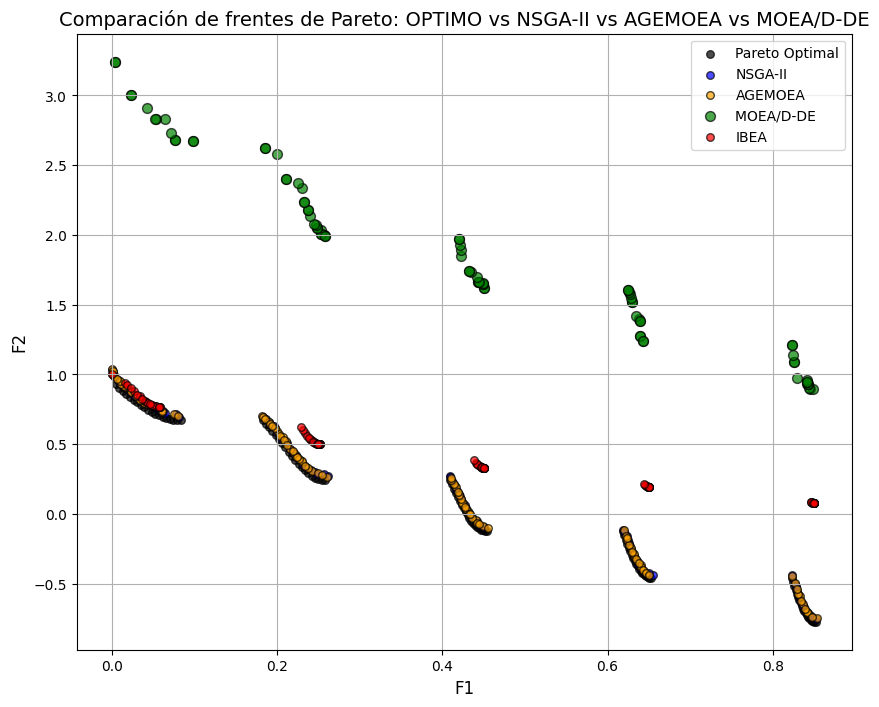

In [7]:
#### VISUALIZACIÓN FRENTES DE PARETO ####

plt.figure(figsize=(10, 8))

# frente de Pareto Optimo
plt.scatter(pareto_optimal[:, 0], pareto_optimal[:, 1], color='black', alpha=0.7, label="Pareto Optimal", edgecolors='black', s=30)

# frente de Pareto obtenido por NSGA-II
plt.scatter(res_nsgaii.F[:, 0], res_nsgaii.F[:, 1], color='blue', alpha=0.7, label="NSGA-II", edgecolors='black', s=30)

# frente de Pareto obtenido por AGEMOEA
plt.scatter(res_agemoea.F[:, 0], res_agemoea.F[:, 1], color='orange', alpha=0.7, label="AGEMOEA", edgecolors='black', s=30)

# frente de Pareto obtenido por MOEA/D-DE
plt.scatter(res_moeadde[:, 0], res_moeadde[:, 1], label="MOEA/D-DE ", color='green', alpha=0.7, edgecolors='black', s=50)

# frente de Pareto obtenido por IBEA
plt.scatter(res_ibea[:, 0], res_ibea[:, 1], label="IBEA", color='red', alpha=0.7, edgecolors='black', s=30)

# Etiquetas
plt.xlabel('F1', fontsize=12)
plt.ylabel('F2', fontsize=12)
plt.title('Comparación de frentes de Pareto: OPTIMO vs NSGA-II vs AGEMOEA vs MOEA/D-DE', fontsize=14)

# Leyenda
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()


# **Múltiple Experimentos**



In [8]:
# FUNCIÓN EJECUCIÓN DE 10 EXPERIMENTOS ALGORITMOS PYMOO
def multiple_experiments(problem, algorithm_class, n_experiments=10, max_evals=10000, pop_size=100):
    '''
    Ejecuta un algoritmo multiobjetivo sobre un problema dado en múltiples experimentos y calcula 
    las métricas de rendimiento (Hipervolumen, Dispersión y Espaciado) para cada ejecución.

    Parámetros:
    - problem: El problema multiobjetivo a resolver.
    - algorithm_class: La clase del algoritmo de optimización multiobjetivo (por ejemplo, NSGA2).
    - n_experiments: Número de experimentos. Por defecto 10.
    - max_evals: Máximo número de evaluaciones por experimento. Por defecto 10,000.
    - pop_size: Tamaño de la población. Por defecto 100.

    Retorna:
    - Promedio y varianza de las métricas (HV, SPR, SPA).
    - Lista de resultados con los frentes de Pareto obtenidos en cada experimento.
    '''
    
    hv_results = []
    spr_results = []
    spa_results = []
    results = []
    
    for i in range(n_experiments):   
        algorithm = algorithm_class(pop_size=pop_size)
        
        # Optimización
        res = minimize(problem,
                    algorithm,
                    termination=('n_eval', max_evals),  # Límite de evaluaciones
                    verbose=False)
        
        # Obtener el frente de Pareto
        pf = res.F  
        
        # Calcular métricas
        hv, spr, spa = calculate_metrics(pf, ref_point=np.array([1.5, 4.0]))  # Asumiendo ref_point como [1.5, 4]
        print(f"\nMétricas Experimento {i+1}:")
        print(f" Hipervolumen (HV): {hv:.4f} ")
        print(f" Dispersión (SPR): {spr:.4f} ")
        print(f" Espaciado (SPA): {spa:.4f} ")
        
        hv_results.append(hv)
        spr_results.append(spr)
        spa_results.append(spa)
        results.append(res)

    
    # Media y varianza de las métricas 
    avg_hv = np.mean(hv_results)
    var_hv = np.var(hv_results)
    
    avg_spr = np.mean(spr_results)
    var_spr = np.var(spr_results)
    
    avg_spa = np.mean(spa_results)
    var_spa = np.var(spa_results)
    
    print(f"\nResultados Promediados y Variados tras {n_experiments} experimentos:")
    print(f"  Promedio de Hipervolumen (HV): {avg_hv:.5f} | Varianza: {var_hv:.5f}")
    print(f"  Promedio de Dispersión (SPR): {avg_spr:.5f} | Varianza: {var_spr:.5f}")
    print(f"  Promedio de Espaciado (SPA): {avg_spa:.5f} | Varianza: {var_spa:.5f}")
    
    return avg_hv, var_hv, avg_spr, var_spr, avg_spa, var_spa, results



# FUNCIÓN EJECUCIÓN DE 10 EXPERIMENTOS ALGORITMOS PROPUESTO
def multiple_experiments_moeadde(n_experiments=10, npop=100, iterations=500, lb=np.array([0]*30), ub=np.array([1]*30), max_evals=10000):
    '''
    Ejecuta el algoritmo MOEA/D-DE múltiples veces y calcula métricas (Hipervolumen, Dispersión y Espaciado) para cada ejecución.

    Parámetros:
    - n_experiments (int): Número de ejecuciones experimentales. Por defecto, 10.
    - npop (int): Tamaño de la población. Por defecto, 100.
    - iterations (int): Número de iteraciones del algoritmo. Por defecto, 500.
    - lb (array): Límite inferior de las variables de decisión. Por defecto, [0]*30.
    - ub (array): Límite superior de las variables de decisión. Por defecto, [1]*30.
    - max_evals (int): Número máximo de evaluaciones de aptitud. Por defecto, 10,000.

    Retorna:
    - Promedio y varianza de las métricas (HV, SPR, SPA) a través de los experimentos.
    - Lista con los frentes de Pareto obtenidos en cada experimento.
    '''
    hv_results = []
    spr_results = []
    spa_results = []
    results = []

    for i in range(n_experiments):

        pf = main_algorithm(npop, iterations, lb, ub, max_evals=max_evals)

        # calcular métricas
        hv, spr, spa = calculate_metrics(pf, ref_point=np.array([1.5, 4.0]))

        print(f"\nMetrics for Experiment {i + 1}:")
        print(f" Hypervolume (HV): {hv:.4f}")
        print(f" Spread (SPR): {spr:.4f}")
        print(f" Spacing (SPA): {spa:.4f}")

        hv_results.append(hv)
        spr_results.append(spr)
        spa_results.append(spa)
        results.append(pf)

    # calcular media y varianza
    avg_hv = np.mean(hv_results)
    var_hv = np.std(hv_results)

    avg_spr = np.mean(spr_results)
    var_spr = np.std(spr_results)

    avg_spa = np.mean(spa_results)
    var_spa = np.std(spa_results)

    print(f"\nResultados Promediados y Variados tras {n_experiments} experimentos:")
    print(f"  Promedio de Hipervolumen (HV): {avg_hv:.5f} | Varianza: {var_hv:.5f}")
    print(f"  Promedio de Dispersión (SPR): {avg_spr:.5f} | Varianza: {var_spr:.5f}")
    print(f"  Promedio de Espaciado (SPA): {avg_spa:.5f} | Varianza: {var_spa:.5f}")
    
    return avg_hv, var_hv, avg_spr, var_spr, avg_spa, var_spa, results

termination_ibea = ('n_eval', 10000)
def multiple_experiments_ibea(problem, termination=termination_ibea, n_experiments=10, pop_size=100):
    
    hv_results = []
    spr_results = []
    spa_results = []
    results = []
    
    for i in range(n_experiments):
        
        # Optimización
        pf = main(npop=100, max_evaluations=10000, lb=lb, ub=ub, nobj=2)
        
        # Calcular métricas
        hv, spr, spa = calculate_metrics(pf, ref_point=ref_point)
        print(f"\nMétricas Experimento {i+1}: Hipervolumen (HV): {hv:.4f}, Dispersión (SPR): {spr:.4f}, Espaciado (SPA): {spa:.4f}")
        
        hv_results.append(hv)
        spr_results.append(spr)
        spa_results.append(spa)
        results.append(pf)

    
    # Media y varianza de las métricas 
    avg_hv = np.mean(hv_results)
    var_hv = np.var(hv_results)
    
    avg_spr = np.mean(spr_results)
    var_spr = np.var(spr_results)
    
    avg_spa = np.mean(spa_results)
    var_spa = np.var(spa_results)
    
    print(f"\nResultados Promediados y Variados tras {n_experiments} experimentos:")
    print(f"  Promedio de Hipervolumen (HV): {avg_hv:.5f} | Varianza: {var_hv:.5f}")
    print(f"  Promedio de Dispersión (SPR): {avg_spr:.5f} | Varianza: {var_spr:.5f}")
    print(f"  Promedio de Espaciado (SPA): {avg_spa:.5f} | Varianza: {var_spa:.5f}")
    
    return avg_hv, var_hv, avg_spr, var_spr, avg_spa, var_spa, results

In [9]:
# Problema
problem = get_problem("zdt3")  

# 1. NSGA-II
print("Ejecutando NSGA-II...")
hv_nsgaii, var_hv_nsgaii, spr_nsgaii, var_spr_nsgaii, spa_nsgaii, var_spa_nsgaii, results_nsgaii = multiple_experiments(problem, NSGA2, n_experiments=10, max_evals=10000)

Ejecutando NSGA-II...

Métricas Experimento 1:
 Hipervolumen (HV): 6.3797 
 Dispersión (SPR): 1.9969 
 Espaciado (SPA): 0.0144 

Métricas Experimento 2:
 Hipervolumen (HV): 6.3781 
 Dispersión (SPR): 1.9821 
 Espaciado (SPA): 0.0148 

Métricas Experimento 3:
 Hipervolumen (HV): 6.4004 
 Dispersión (SPR): 1.9776 
 Espaciado (SPA): 0.0130 

Métricas Experimento 4:
 Hipervolumen (HV): 6.3786 
 Dispersión (SPR): 1.9903 
 Espaciado (SPA): 0.0134 

Métricas Experimento 5:
 Hipervolumen (HV): 6.3812 
 Dispersión (SPR): 1.9783 
 Espaciado (SPA): 0.0131 

Métricas Experimento 6:
 Hipervolumen (HV): 6.3610 
 Dispersión (SPR): 1.9991 
 Espaciado (SPA): 0.0141 

Métricas Experimento 7:
 Hipervolumen (HV): 6.3691 
 Dispersión (SPR): 2.0182 
 Espaciado (SPA): 0.0126 

Métricas Experimento 8:
 Hipervolumen (HV): 6.3929 
 Dispersión (SPR): 1.9870 
 Espaciado (SPA): 0.0154 

Métricas Experimento 9:
 Hipervolumen (HV): 6.3531 
 Dispersión (SPR): 1.9774 
 Espaciado (SPA): 0.0135 

Métricas Experimento 10

In [10]:
# Problema
problem = get_problem("zdt3")  

# 2. AGEMOEA
print("Ejecutando AGEMOEA...")
hv_agemoea, var_hv_agemoea, spr_agemoea, var_spr_agemoea, spa_agemoea, var_spa_agemoea, results_agemoea = multiple_experiments(problem, AGEMOEA, n_experiments=10, max_evals=10000)

Ejecutando AGEMOEA...

Métricas Experimento 1:
 Hipervolumen (HV): 6.3927 
 Dispersión (SPR): 1.9843 
 Espaciado (SPA): 0.0143 

Métricas Experimento 2:
 Hipervolumen (HV): 6.3946 
 Dispersión (SPR): 1.9809 
 Espaciado (SPA): 0.0137 

Métricas Experimento 3:
 Hipervolumen (HV): 6.4008 
 Dispersión (SPR): 1.9726 
 Espaciado (SPA): 0.0130 

Métricas Experimento 4:
 Hipervolumen (HV): 6.3918 
 Dispersión (SPR): 1.9829 
 Espaciado (SPA): 0.0127 

Métricas Experimento 5:
 Hipervolumen (HV): 6.1741 
 Dispersión (SPR): 1.6143 
 Espaciado (SPA): 0.0118 

Métricas Experimento 6:
 Hipervolumen (HV): 6.3920 
 Dispersión (SPR): 1.9836 
 Espaciado (SPA): 0.0139 

Métricas Experimento 7:
 Hipervolumen (HV): 6.3981 
 Dispersión (SPR): 1.9747 
 Espaciado (SPA): 0.0144 

Métricas Experimento 8:
 Hipervolumen (HV): 6.3870 
 Dispersión (SPR): 1.9838 
 Espaciado (SPA): 0.0139 

Métricas Experimento 9:
 Hipervolumen (HV): 6.3919 
 Dispersión (SPR): 1.9788 
 Espaciado (SPA): 0.0134 

Métricas Experimento 10

In [11]:
# Problema
problem = get_problem("zdt3")  

# 3. MOEAD/DE
print("Ejecutando MOEAD/D-DE...")
hv_moeadde, var_hv_moeadde,spr_moeadde, var_spr_moeadde, spa_moeadde, var_spa_moeadde , results_moeadde= multiple_experiments_moeadde()

Ejecutando MOEAD/D-DE...
Iteración 10 completada. Evaluaciones: 1000/10000
Iteración 20 completada. Evaluaciones: 2000/10000
Iteración 30 completada. Evaluaciones: 3000/10000
Iteración 40 completada. Evaluaciones: 4000/10000
Iteración 50 completada. Evaluaciones: 5000/10000
Iteración 60 completada. Evaluaciones: 6000/10000
Iteración 70 completada. Evaluaciones: 7000/10000
Iteración 80 completada. Evaluaciones: 8000/10000
Iteración 90 completada. Evaluaciones: 9000/10000

Metrics for Experiment 1:
 Hypervolume (HV): 4.4294
 Spread (SPR): 2.9116
 Spacing (SPA): 0.0215
Iteración 10 completada. Evaluaciones: 1000/10000
Iteración 20 completada. Evaluaciones: 2000/10000
Iteración 30 completada. Evaluaciones: 3000/10000
Iteración 40 completada. Evaluaciones: 4000/10000
Iteración 50 completada. Evaluaciones: 5000/10000
Iteración 60 completada. Evaluaciones: 6000/10000
Iteración 70 completada. Evaluaciones: 7000/10000
Iteración 80 completada. Evaluaciones: 8000/10000
Iteración 90 completada. Ev

In [13]:
lb = np.array([0] * 7)
ub = np.array([1] * 7)
avg_hv_ibea, var_hv_ibea, avg_spr_ibea, var_spr_ibea, avg_spa_ibea, var_spa_ibea, results_ibea = multiple_experiments_ibea(problem, n_experiments=10)


Métricas Experimento 1: Hipervolumen (HV): 5.5221, Dispersión (SPR): 1.2545, Espaciado (SPA): 0.0049

Métricas Experimento 2: Hipervolumen (HV): 5.5539, Dispersión (SPR): 1.2544, Espaciado (SPA): 0.0039

Métricas Experimento 3: Hipervolumen (HV): 5.4795, Dispersión (SPR): 1.0362, Espaciado (SPA): 0.0054

Métricas Experimento 4: Hipervolumen (HV): 5.5542, Dispersión (SPR): 1.2545, Espaciado (SPA): 0.0046

Métricas Experimento 5: Hipervolumen (HV): 5.4794, Dispersión (SPR): 1.0362, Espaciado (SPA): 0.0048

Métricas Experimento 6: Hipervolumen (HV): 5.4793, Dispersión (SPR): 1.0362, Espaciado (SPA): 0.0051

Métricas Experimento 7: Hipervolumen (HV): 5.4794, Dispersión (SPR): 1.0362, Espaciado (SPA): 0.0051

Métricas Experimento 8: Hipervolumen (HV): 5.5228, Dispersión (SPR): 1.2544, Espaciado (SPA): 0.0056

Métricas Experimento 9: Hipervolumen (HV): 5.4792, Dispersión (SPR): 1.0362, Espaciado (SPA): 0.0051

Métricas Experimento 10: Hipervolumen (HV): 5.5540, Dispersión (SPR): 1.2544, Esp

Visualización de los mejores resultados **según el valor del hipervolúmen**

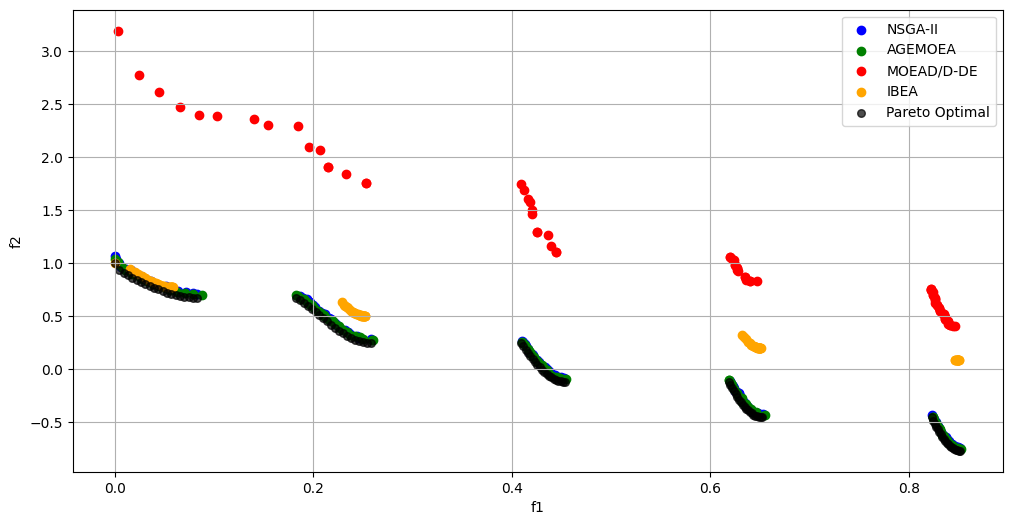

In [14]:
#### FRENTE DE MEJORES RESULTADOS ####

best_experiment_index_nsgaii = np.argmax(hv_nsgaii)  
best_pf_nsgaii = results_nsgaii[best_experiment_index_nsgaii].F 
best_experiment_index_agemoea = np.argmax(hv_agemoea)  
best_pf_agemoea = results_agemoea[best_experiment_index_agemoea].F 
best_experiment_index_moeadde = np.argmax(hv_moeadde)  
best_pf_moeadde = results_moeadde[best_experiment_index_moeadde]
best_experiment_index_ibea = np.argmax(avg_hv_ibea)
best_pf_ibea = results_ibea[best_experiment_index_ibea]


plt.figure(figsize=(12, 6))
plt.scatter(best_pf_nsgaii[:, 0], best_pf_nsgaii[:, 1], label="NSGA-II", color='blue')
plt.scatter(best_pf_agemoea[:, 0], best_pf_agemoea[:, 1], label="AGEMOEA", color='green')
plt.scatter(best_pf_moeadde[:, 0], best_pf_moeadde[:, 1], label="MOEAD/D-DE", color='red')
plt.scatter(best_pf_ibea[:, 0], best_pf_ibea[:, 1], label="IBEA", color='orange')
# frente de Pareto Optimo
plt.scatter(pareto_optimal[:, 0], pareto_optimal[:, 1], color='black', alpha=0.7, label="Pareto Optimal", edgecolors='black', s=30)

plt.xlabel("f1")
plt.ylabel("f2")
plt.legend()
plt.grid(True)
plt.show()